In [1]:
%cd ..

/home/jim/art-guide


In [2]:
from reverse_image_search_module.resnet18 import img2vec
import numpy as np
import pandas as pd
import torch
from PIL import Image
import cv2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from reverse_image_search_module.search_image import find_image

/home/jim/art-guide/reverse_image_search_module/search_image.py:19: RuntimeWarning: invalid value encountered in divide
  vec = vec / np.linalg.norm(vec)


In [4]:
from PIL import Image

image_path = '/home/jim/art-guide/data/img/full/feb62e0096317b14a1e5e63441eb756f77af2948.jpg'
image = Image.open(image_path)
feature_vector = img2vec.getVectors(image)

idx, dist, data = find_image(image,n=2)

print("Index:", idx)
print("Distance:", dist)
# print("Distance2:", dist2)
print("Data:", data)

Index: [97081, 86580]
Distance: [0.9999999403953552, 0.9003384709358215]
Data: [{'author_name': 'Hans Heysen', 'style': 'Realism', 'date': '1930', 'id': 99058, 'url': 'https://www.wikiart.org/en/hans-heysen/the-druid-s-range-hawker-1930', 'title': "The Druid's Range, Hawker", 'original_title': nan, 'series': nan, 'genre': 'landscape', 'media': nan, 'location': nan, 'dimension': nan, 'description': nan, 'tags': 'Mountainouslandforms,Mountain,Mountainrange,Geology', 'image_url': 'https://uploads2.wikiart.org/images/hans-heysen/the-druid-s-range-hawker-1930.jpg', 'file_name': 'feb62e0096317b14a1e5e63441eb756f77af2948.jpg'}, {'author_name': 'Hans Heysen', 'style': 'Realism', 'date': '1932', 'id': 99066, 'url': 'https://www.wikiart.org/en/hans-heysen/mt-bryan-mid-north-1932', 'title': 'Mt. Bryan, mid north', 'original_title': nan, 'series': nan, 'genre': 'landscape', 'media': nan, 'location': nan, 'dimension': nan, 'description': nan, 'tags': 'Mountainouslandforms,Mountain,Mountainrange,Bad

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
import os
folder_path = '/home/jim/art-guide/data/img/full/'
image_files = os.listdir(folder_path)[:1000] 
file_distances = {}
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    # feature_vector = img2vec.getVectors(image)
    idx, dist, data, = find_image(image)
    file_distances[image_file] = dist


In [9]:
from os.path import basename


In [10]:
import os
from PIL import Image
import torchvision.transforms as transforms
folder_path = '/home/jim/art-guide/data/img/full/'

augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    # transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
image_files = os.listdir(folder_path)[:1000]  
file_distances_aug = {}
file_distances_aug_second = {}

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    
    image = Image.open(image_path)
    
    augmented_image = augmentation_transforms(image)
    
    # feature_vector = img2vec.getVectors(augmented_image)
    idx, dist, data = find_image(augmented_image,n=2)

    for i, di, da in zip(idx, dist, data):
        if da["file_name"] == basename(image_file):
            file_distances_aug[image_file] = di
        else:
            file_distances_aug_second[image_file + str(i)] = di

assert len(file_distances_aug) > 0
assert len(file_distances_aug_second) > 0
print(len(file_distances_aug), len(file_distances_aug_second))

624 1376


In [11]:
y_test, y_score = [], []
for k, v in file_distances_aug.items():
    y_test.append(1)
    y_score.append(v)

for k, v in file_distances_aug_second.items():
    y_test.append(0)
    y_score.append(v)

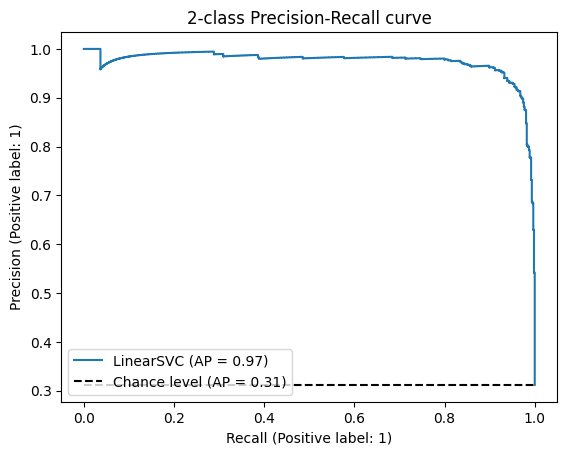

In [12]:
import sklearn
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [13]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

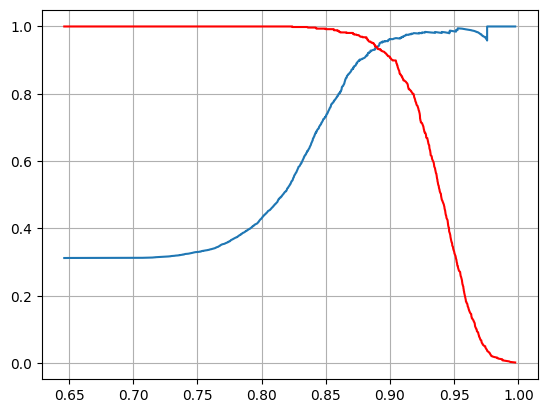

In [14]:
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1])
plt.plot(thresholds, recall[:-1], color='red')
plt.grid()

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_score)
print(roc_auc)

0.9906245341383423


In [9]:
print(list(file_distances.values())[6])

1.0000001192092896


In [10]:
print(list(file_distances_aug.values())[6])

0.8059111833572388


In [11]:
# image = Image.open('/home/jim/art-guide/data/img/full/a788e49cf61f4eb5fe2bf9e22e698eef978fd067.jpg')
# image.show()

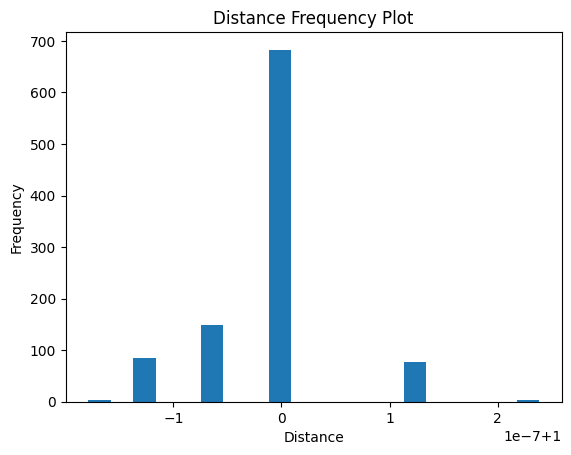

In [16]:
import matplotlib.pyplot as plt
values = list(file_distances.values())
plt.hist(values, bins=20)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distance Frequency Plot')
plt.show()

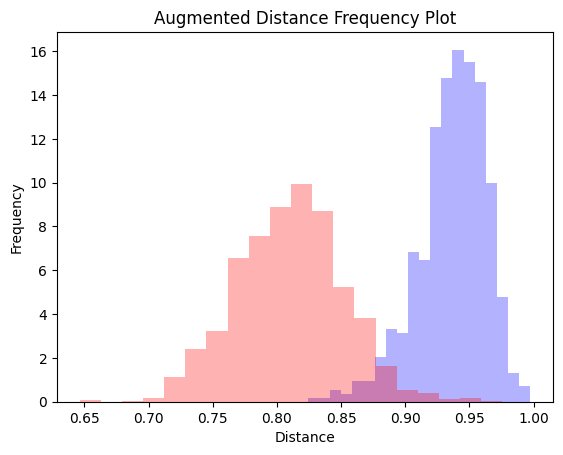

In [17]:
values_aug = list(file_distances_aug.values())
plt.hist(values_aug, bins=20, color='blue',alpha=0.3,density=True)
values_aug_second = list(file_distances_aug_second.values())
plt.hist(values_aug_second, bins=20, color='red',alpha=0.3,density=True)

# pd.Series(values_aug).plot(kind='kde', color='blue')
# values = list(file_distances.values())
# pd.Series(values).plot(kind='kde', color='red')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Augmented Distance Frequency Plot')
plt.show()

In [ ]:
roc_auc + value
precision recall

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


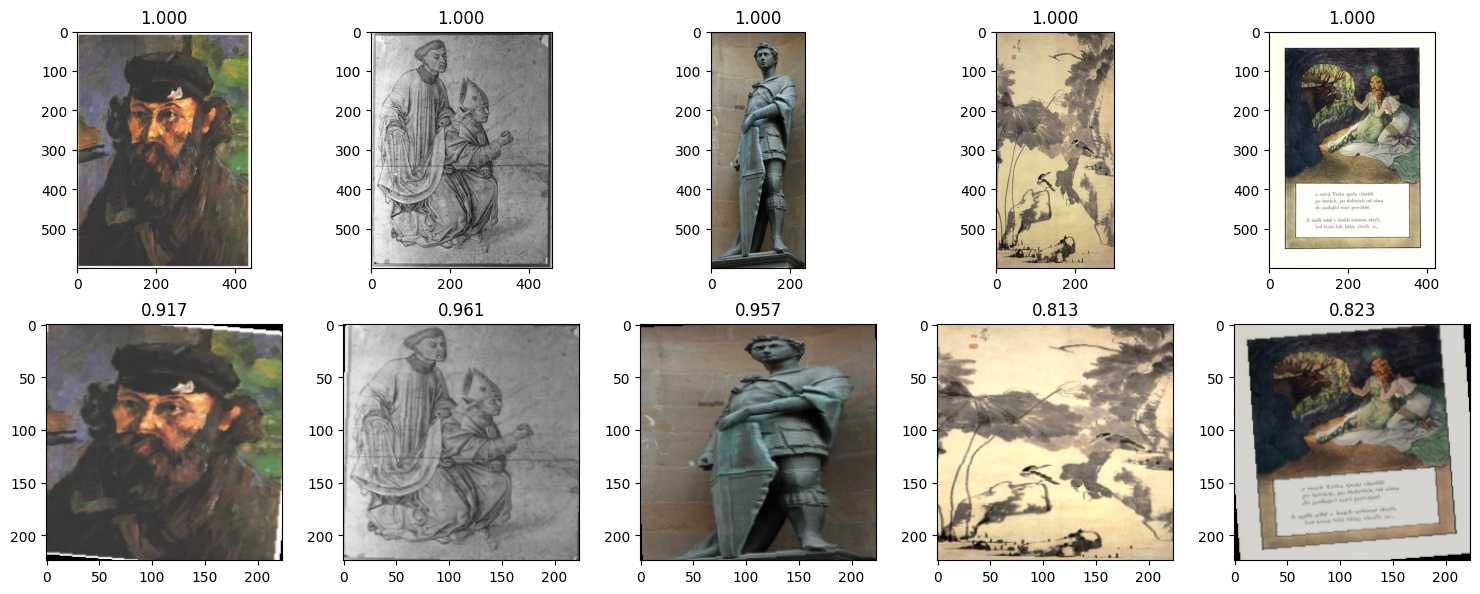

In [18]:
folder_path = '/home/jim/art-guide/data/img/full/'

augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(5),
    # transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
image_files = os.listdir(folder_path)[50:55] 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    # image = cv2.imread(image_path)
    # image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    augmented_image = augmentation_transforms(image)
    axs[0, i].imshow(image)
    # feature_vector = img2vec.getVectors(image)
    idx, dist, data = find_image(image)
    axs[0, i].set_title(f'{dist:.3f}')
    feature_vector_aug = img2vec.getVectors(augmented_image)
    idx, dist_aug, data = find_image(augmented_image)
    # print(dist:.3f)
    # print(dist_aug)
    augmented_image = augmented_image.permute(1, 2, 0) 
    axs[1, i].imshow(augmented_image)
    axs[1, i].set_title(f'{dist_aug:.3f}')

plt.tight_layout()
plt.show()